<a href="https://colab.research.google.com/github/Bharath26214/IntelChallenge/blob/main/clustering_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from PIL import Image
from io import BytesIO
from IPython.display import display

import requests

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [ ]:
zoom_factor = 8
india_center = '23.5120,80.3290'
TN_center = '11.1271,78.6569'

api_key = 'pk.e9bb91c83a2dc4b1e4620f895bc9f75f'
base_endpoint = 'https://us1.locationiq.com/v1/search'

hp_endpoint = 'https://us1.locationiq.com/v1/nearby'
map_endpoint = 'https://maps.locationiq.com/v3/staticmap'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/unnati_phase1_data_revised.csv')

In [ ]:
df.head()

,Alert,Date,Time,Lat,Long,Vehicle,Speed
0,cas_ldw,2022-06-01,05:36:36,12.887403,80.083412,2846,48
1,cas_ldw,2022-06-01,05:36:47,12.892586,80.085794,2846,58
2,cas_ldw,2022-06-01,05:37:04,12.894932,80.087564,2846,57
3,cas_ldw,2022-06-01,05:37:31,12.898267,80.090062,2846,49
4,cas_ldw,2022-06-01,05:38:08,12.901594,80.092538,2846,58


In [ ]:
df.isnull().sum()

Alert      0
Date       0
Time       0
Lat        0
Long       0
Vehicle    0
Speed      0
dtype: int64

In [ ]:
df.dtypes

Alert       object
Date        object
Time        object
Lat        float64
Long       float64
Vehicle      int64
Speed        int64
dtype: object

In [ ]:
df.shape

(21325, 7)

In [ ]:
df['Alert'].value_counts()

cas_hmw    12328
cas_ldw     6431
cas_pcw     1976
cas_fcw      590
Name: Alert, dtype: int64

In [ ]:
df['Vehicle'].value_counts()

805     6875
5339    5842
2846    5686
3143    2904
1995      18
Name: Vehicle, dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.head()

,Alert,Date,Time,Lat,Long,Vehicle,Speed
0,cas_ldw,2022-06-01,05:36:36,12.887403,80.083412,2846,48
1,cas_ldw,2022-06-01,05:36:47,12.892586,80.085794,2846,58
2,cas_ldw,2022-06-01,05:37:04,12.894932,80.087564,2846,57
3,cas_ldw,2022-06-01,05:37:31,12.898267,80.090062,2846,49
4,cas_ldw,2022-06-01,05:38:08,12.901594,80.092538,2846,58


# **Unsafe Areas for pedestrains**

In [ ]:
start = pd.to_datetime('2022-06-01')
end = pd.to_datetime('2022-06-07')

pcw_fcw = df[ (df['Speed'] > 40) & (df['Alert']=='cas_pcw') | (df['Speed'] > 50) & (df['Alert'] == 'cas_fcw')]
pcw_df = df[ (df['Speed'] > 40) & (df['Alert']=='cas_pcw')]

In [ ]:
fig = px.scatter_mapbox(pcw_fcw, lat='Lat', lon='Long', hover_name='Alert', color='Alert', hover_data=['Date', 'Speed', 'Vehicle'],
                        zoom=8, height=600)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

fig.show()

In [ ]:
coordinates_rad = []
for i in range(len(pcw_df)):
  coordinates_rad.append((radians(pcw_df['Lat'].iloc[i]), radians(pcw_df['Long'].iloc[i])))

distance_matrix = haversine_distances(coordinates_rad)

epsilon = 0.0005
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(distance_matrix)

# Print the cluster labels
print("Cluster labels:", labels)


Cluster labels: [ 0 -1  1  2 -1  1 -1  1  1  1  1  3  1  3  3 -1  0 -1  4 -1  1  4  2  1
  3  2  3  0  2 -1  1  1  0  1  2 -1  3  3  4  3  1 -1  1 -1  1 -1  1  1
  5  1  4 -1 -1 -1  0 -1  4  5  1  2  1  1  4 -1  1 -1  5  1  1 -1  5  5
  5  5  0  1  0  4  3  0  0 -1  2  1  0  5  1  0]


In [ ]:
pcw_df['labels'] = labels

<ipython-input-16-fa2428278573>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
pcw_df[pcw_df['labels'] == 5]['Date'].value_counts()

2022-08-12    4
2022-08-04    1
2022-08-09    1
2022-08-15    1
2022-08-23    1
Name: Date, dtype: int64

In [ ]:
cluster_centers = []

unique_labels = np.unique(labels)

centroid_lat_pcw = []
centroid_lon_pcw = []

for label in unique_labels:
    if label == -1:
        continue

    cluster_indices = np.where(labels == label)[0]

    cluster_coords = [coordinates_rad[i] for i in cluster_indices]

    centroid_lat = np.mean([lat for lat, lon in cluster_coords])
    centroid_lon = np.mean([lon for lat, lon in cluster_coords])

    centroid_lat_pcw.append(np.degrees(centroid_lat))
    centroid_lon_pcw.append(np.degrees(centroid_lon))


In [ ]:
cluster_pcw = pd.DataFrame({'lat':centroid_lat_pcw, 'lon':centroid_lon_pcw})

In [ ]:
#clustered map
fig = px.scatter_mapbox(cluster_pcw, lat='lat', lon='lon', hover_data=['lat', 'lon'],
                        zoom=8, height=600)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

fig.show()

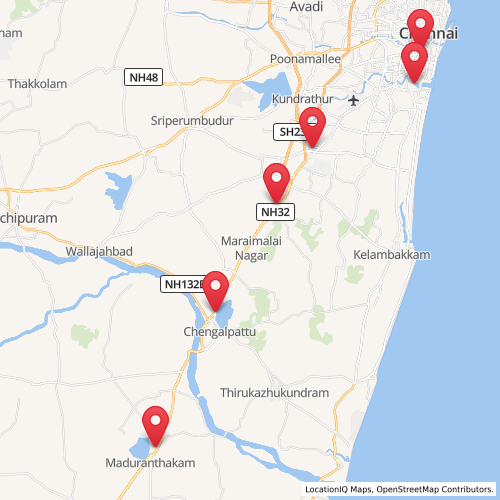

In [ ]:
pcw_coordinates = []

for i in range(len(centroid_lat_pcw)):
    pcw_coordinates.append(str(centroid_lat_pcw[i]) + ',' + str(centroid_lon_pcw[i]))

pcw_markers = '|'.join([f'icon:small-red-cutout|{coord}' for coord in pcw_coordinates])


pcw_params = {'key': api_key, 'center':'12.7930,80.0252','size': '500x500', 'marker': pcw_markers}

pcw_resp = requests.get(map_endpoint, params=pcw_params)

pcw_image = Image.open(BytesIO(pcw_resp.content))

display(pcw_image)

In [ ]:
rg_endpoint = 'https://us1.locationiq.com/v1/reverse'

unsafe_for_pedestrains = []

for i in range(len(centroid_lat_pcw)):
  params = {'key':api_key, 'lat':str(centroid_lat_pcw[i]), 'lon':str(centroid_lon_pcw[i]), 'format':'json'}
  response = requests.get(rg_endpoint, params=params)
  if response.status_code == 200:
    unsafe = response.json()
    unsafe_for_pedestrains.append(unsafe['address'])


In [ ]:
# Areas unsafe for pedestrains
[
    {
        'car': 'Sundaram Motors', 'road': 'Whites Road', 'neighbourhood': 'CMWSSB Division 111',
        'suburb': 'Zone 9 Teynampet', 'city': 'Chennai', 'state_district': 'Chennai District',
        'state': 'Tamil Nadu', 'postcode': '600001', 'country': 'India', 'country_code': 'in'
    },

    {
        'road': 'Chennai - Trichy - Dindugal Road (Old NH45)', 'suburb': 'Natham',
        'village': 'Pulippākkam', 'county': 'Chengalpattu', 'state_district': 'Chengalpattu District',
        'state': 'Tamil Nadu', 'postcode': '603001', 'country': 'India', 'country_code': 'in'
    },

    {
        'suburb': 'Urapakkam', 'village': 'Guduvancheri', 'county': 'Chengalpattu',
        'state_district': 'Chengalpattu District', 'state': 'Tamil Nadu',
        'postcode': '603202', 'country': 'India', 'country_code': 'in'
    },

    {
        'road': 'Grand Southern Trunk Road', 'village': 'Bukkathurai', 'town': 'Maduranthakam',
        'state_district': 'Chengalpattu District', 'state': 'Tamil Nadu',
        'postcode': '603303', 'country': 'India', 'country_code': 'in'
    },

    {
        'road': 'Adyar River Pathway', 'neighbourhood': 'CMWSSB Division 175',
        'suburb': 'Zone 13 Adyar', 'city': 'Chennai', 'state_district': 'Chennai District',
        'state': 'Tamil Nadu', 'postcode': '600001', 'country': 'India', 'country_code': 'in'
    },

    {
        'hospital': 'Dhanwantralaya', 'road': 'Sivanandam Street', 'suburb': 'Irumbuliyur',
        'city': 'Tambaram', 'county': 'Tambaram', 'state_district': 'Chengalpattu District',
        'state': 'Tamil Nadu', 'postcode': '600045', 'country': 'India', 'country_code': 'in'
    }
]

[{'car': 'Sundaram Motors',
  'road': 'Whites Road',
  'neighbourhood': 'CMWSSB Division 111',
  'suburb': 'Zone 9 Teynampet',
  'city': 'Chennai',
  'state_district': 'Chennai District',
  'state': 'Tamil Nadu',
  'postcode': '600001',
  'country': 'India',
  'country_code': 'in'},
 {'road': 'Chennai - Trichy - Dindugal Road (Old NH45)',
  'suburb': 'Natham',
  'village': 'Pulippākkam',
  'county': 'Chengalpattu',
  'state_district': 'Chengalpattu District',
  'state': 'Tamil Nadu',
  'postcode': '603001',
  'country': 'India',
  'country_code': 'in'},
 {'suburb': 'Urapakkam',
  'village': 'Guduvancheri',
  'county': 'Chengalpattu',
  'state_district': 'Chengalpattu District',
  'state': 'Tamil Nadu',
  'postcode': '603202',
  'country': 'India',
  'country_code': 'in'},
 {'road': 'Grand Southern Trunk Road',
  'village': 'Bukkathurai',
  'town': 'Maduranthakam',
  'state_district': 'Chengalpattu District',
  'state': 'Tamil Nadu',
  'postcode': '603303',
  'country': 'India',
  'coun

# **Risk Areas due to more number in FCW Alerts**

In [ ]:
fcw_df = df[(df['Speed'] > 50) & (df['Alert'] == 'cas_fcw')]

In [ ]:
coordinates_rad = []
for i in range(len(fcw_df)):
  coordinates_rad.append((radians(fcw_df['Lat'].iloc[i]), radians(fcw_df['Long'].iloc[i])))

distance_matrix = haversine_distances(coordinates_rad)

epsilon = 0.0004
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(distance_matrix)

# Print the cluster labels
print("Cluster labels:", labels)


Cluster labels: [ 3  0  1  0  2  1  0  0  0  0  0  3 -1 -1  2  1 -1  2 -1  0 -1  3  2  0
  0  0  0  3  2  2  0  0  0  0  0 -1  3  2  2  2 -1  3  0  0  0  3  2  0
  2  0  3 -1 -1  0  1  1  0  0  0  0  2  0  0  0  0  3  0  2  0  0  0  2
 -1  2 -1  1  0  0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  2  0  0  1
  0  0  0  0  0  2 -1]


In [ ]:
cluster_centers = []

unique_labels = np.unique(labels)

centroid_lat_fcw = []
centroid_lon_fcw = []

for label in unique_labels:
    if label == -1:
        continue

    cluster_indices = np.where(labels == label)[0]

    cluster_coords = [coordinates_rad[i] for i in cluster_indices]

    centroid_lat = np.mean([lat for lat, lon in cluster_coords])
    centroid_lon = np.mean([lon for lat, lon in cluster_coords])

    centroid_lat_fcw.append(np.degrees(centroid_lat))
    centroid_lon_fcw.append(np.degrees(centroid_lon))


In [ ]:
cluster_fcw = pd.DataFrame({'lat':centroid_lat_fcw, 'lon':centroid_lon_fcw})

#clustered map
fig = px.scatter_mapbox(cluster_fcw, lat='lat', lon='lon', hover_data=['lat', 'lon'],
                        zoom=8, height=600)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

fig.show()

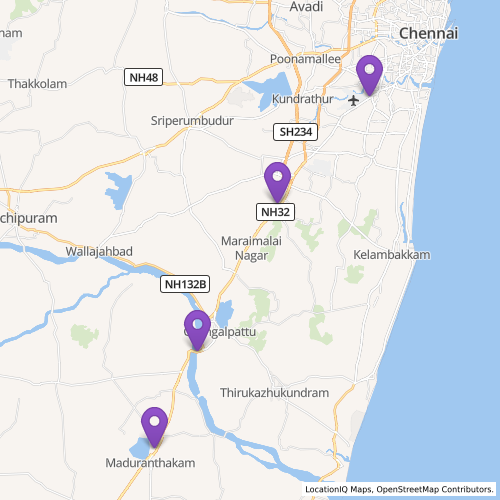

In [ ]:
fcw_coordinates = []

for i in range(len(centroid_lat_fcw)):
    fcw_coordinates.append(str(centroid_lat_fcw[i]) + ',' + str(centroid_lon_fcw[i]))

fcw_markers = '|'.join([f'icon:small-purple-cutout|{coord}' for coord in fcw_coordinates])


fcw_params = {'key': api_key, 'center':'12.7930,80.0252', 'size':'500x500', 'marker': fcw_markers}

fcw_resp = requests.get(map_endpoint, params=fcw_params)

fcw_image = Image.open(BytesIO(fcw_resp.content))

display(fcw_image)

In [ ]:
rg_endpoint = 'https://us1.locationiq.com/v1/reverse'

highalert_areas = []

for i in range(len(centroid_lat_fcw)):
  params = {'key':api_key, 'lat':str(centroid_lat_fcw[i]), 'lon':str(centroid_lon_fcw[i]), 'format':'json'}
  response = requests.get(rg_endpoint, params=params)
  if response.status_code == 200:
    risky = response.json()
    highalert_areas.append(risky['address'])


In [ ]:
[
    {
        'suburb': 'Urapakkam',
        'village': 'Guduvancheri',
        'county': 'Chengalpattu',
        'state_district': 'Chengalpattu District',
        'state': 'Tamil Nadu',
        'postcode': '603202',
        'country': 'India',
        'country_code': 'in'
    },

    {
        'town': 'Maduranthakam',
        'state_district': 'Chengalpattu District',
        'state': 'Tamil Nadu',
        'postcode': '603303',
        'country': 'India',
        'country_code': 'in'
    },

    {
        'village': 'Irunkunrapalli',
        'county': 'Chengalpattu',
        'state_district': 'Chengalpattu District',
        'state': 'Tamil Nadu',
        'postcode': '603201',
        'country': 'India',
        'country_code': 'in'
    }
]

[{'suburb': 'Urapakkam',
  'village': 'Guduvancheri',
  'county': 'Chengalpattu',
  'state_district': 'Chengalpattu District',
  'state': 'Tamil Nadu',
  'postcode': '603202',
  'country': 'India',
  'country_code': 'in'},
 {'town': 'Maduranthakam',
  'state_district': 'Chengalpattu District',
  'state': 'Tamil Nadu',
  'postcode': '603303',
  'country': 'India',
  'country_code': 'in'},
 {'village': 'Irunkunrapalli',
  'county': 'Chengalpattu',
  'state_district': 'Chengalpattu District',
  'state': 'Tamil Nadu',
  'postcode': '603201',
  'country': 'India',
  'country_code': 'in'}]

In [ ]:
fcw_df = df[(df['Alert'] == 'cas_fcw') & (df['Speed'] > 50)]

len(fcw_df)

103

In [ ]:
fig = px.scatter_mapbox(data_frame=fcw_df, lat='Lat', lon='Long', text='Alert', color='Alert',
                        hover_name='Speed', hover_data=['Lat', 'Long', 'Date'],
                        zoom=3)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

fig.show()


In [ ]:
hp_params = {'key': api_key, 'lat':12.887403	, 'lon':80.083412	, 'tag':'hospital', 'limit':20, 'radius':3000, 'format':'json'}

hp_response = requests.get(hp_endpoint, params=hp_params)

sample_1 = 'https://us1.locationiq.com/v1/search?key=<Your_API_Access_Token>&q=221b%2C%20Baker%20St%2C%20London%20&format=json'
sample_2 = 'https://us1.locationiq.com/v1/nearby?key=YOUR_ACCESS_TOKEN&lat=LATITUDE&lon=LONGITUDE&tag=POI&radius=IN_METERS&format=json'

In [ ]:
coordinates_rad = []
for i in range(len(df)):
  coordinates_rad.append((radians(df['Lat'].iloc[i]), radians(df['Long'].iloc[i])))

distance_matrix = haversine_distances(coordinates_rad)

epsilon = 0.00005
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(distance_matrix)

# Print the cluster labels
print("Cluster labels:", labels)


Cluster labels: [0 0 0 ... 0 0 0]


In [ ]:
cluster_centers = []

unique_labels = np.unique(labels)

centroid_lat_bs = []
centroid_lon_bs = []

for label in unique_labels:
    if label == -1:
        continue

    cluster_indices = np.where(labels == label)[0]

    cluster_coords = [coordinates_rad[i] for i in cluster_indices]

    centroid_lat = np.mean([lat for lat, lon in cluster_coords])
    centroid_lon = np.mean([lon for lat, lon in cluster_coords])

    centroid_lat_bs.append(np.degrees(centroid_lat))
    centroid_lon_bs.append(np.degrees(centroid_lon))


In [ ]:
hp_data = []

for i in range(len(centroid_lat_bs)):
  hp_params = {'key': api_key, 'lat':centroid_lat_bs[i]	, 'lon':centroid_lon_bs[i]	, 'tag':'hospital', 'limit':20, 'radius':3000, 'format':'json'}

  hp_response = requests.get(hp_endpoint, params=hp_params)

  if hp_response.status_code == 200:
    res = hp_response.json()
    hp_data.append(res)

In [ ]:
hp_data

[[{'place_id': '424180873104',
   'osm_type': 'node',
   'osm_id': '7820874287',
   'lat': '12.911081',
   'lon': '80.0964005',
   'class': 'amenity',
   'type': 'hospital',
   'tag_type': 'hospital',
   'name': 'Sri Raghav Child Care Centre',
   'display_name': 'Sri Raghav Child Care Centre, KM 28/1 of GST Road to Peerkankaranai Road, Tambaram, Tamil Nadu, 600063, India',
   'address': {'name': 'Sri Raghav Child Care Centre',
    'road': 'KM 28/1 of GST Road to Peerkankaranai Road',
    'city': 'Tambaram',
    'state': 'Tamil Nadu',
    'postcode': '600063',
    'country': 'India',
    'country_code': 'IN'},
   'boundingbox': ['12.911081', '12.911081', '80.0964005', '80.0964005'],
   'distance': 2696},
  {'place_id': '420721048754',
   'osm_type': 'node',
   'osm_id': '5259008321',
   'lat': '12.8917407',
   'lon': '80.1412614',
   'class': 'amenity',
   'type': 'hospital',
   'tag_type': 'hospital',
   'name': 'Annai Therasa Hospital',
   'display_name': 'Annai Therasa Hospital, Camp

In [ ]:
hp_lat = []
hp_lon = []
hp_name = []

for i in range(len(hp_data)):
  for j in range(len(hp_data[i])):
    hp_name.append(hp_data[i][j]['name'])
    hp_lat.append(hp_data[i][j]['lat'])
    hp_lon.append(hp_data[i][j]['lon'])

hpdf = pd.DataFrame({'hospital name':hp_name, 'lat':hp_lat, 'lon':hp_lon})

hpdf['lat'] = pd.to_numeric(hpdf['lat'])
hpdf['lon'] = pd.to_numeric(hpdf['lon'])



In [ ]:
fig = px.scatter_mapbox(data_frame=hpdf, lat='lat', lon='lon', text='hospital name',
                        hover_data=['lat', 'lon'],
                        zoom=3)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

black_spots = {'lat': centroid_lat_bs, 'lon': centroid_lon_bs}
black_spots_df = pd.DataFrame(black_spots)
new_trace = px.scatter_mapbox(black_spots_df, lat='lat', lon='lon', color_discrete_sequence=['red']).data[0]
fig.add_trace(new_trace)

fig.show()

In [ ]:
df.head()

,Alert,Date,Time,Lat,Long,Vehicle,Speed
0,cas_ldw,2022-06-01,05:36:36,12.887403,80.083412,2846,48
1,cas_ldw,2022-06-01,05:36:47,12.892586,80.085794,2846,58
2,cas_ldw,2022-06-01,05:37:04,12.894932,80.087564,2846,57
3,cas_ldw,2022-06-01,05:37:31,12.898267,80.090062,2846,49
4,cas_ldw,2022-06-01,05:38:08,12.901594,80.092538,2846,58


In [ ]:
alert_counts = df['Date'].value_counts()

print(alert_counts)

2022-06-21    707
2022-06-03    695
2022-06-06    667
2022-08-08    637
2022-08-04    625
2022-08-09    619
2022-08-17    612
2022-08-12    605
2022-08-05    604
2022-08-15    599
2022-06-16    578
2022-06-17    577
2022-08-10    574
2022-06-02    562
2022-06-20    553
2022-08-16    549
2022-08-02    548
2022-07-01    535
2022-06-01    515
2022-08-11    501
2022-08-03    499
2022-06-25    497
2022-06-15    496
2022-06-30    490
2022-08-19    487
2022-06-27    481
2022-06-28    454
2022-06-07    435
2022-06-29    400
2022-06-09    397
2022-08-22    380
2022-06-23    375
2022-06-08    367
2022-08-18    362
2022-06-11    342
2022-06-10    328
2022-08-23    314
2022-06-24    282
2022-06-14    279
2022-08-31    276
2022-08-24    274
2022-08-29    243
2022-08-25    241
2022-08-14    178
2022-08-30    172
2022-08-06    144
2022-06-13    136
2022-08-26     59
2022-06-04     49
2022-08-13     22
2022-06-22      4
Name: Date, dtype: int64


In [ ]:
timeline_df = pd.DataFrame({'Date':alert_counts.index, 'count':alert_counts.values})
timeline_df

,Date,count
0,2022-06-21,707
1,2022-06-03,695
2,2022-06-06,667
3,2022-08-08,637
4,2022-08-04,625
5,2022-08-09,619
6,2022-08-17,612
7,2022-08-12,605
8,2022-08-05,604
9,2022-08-15,599


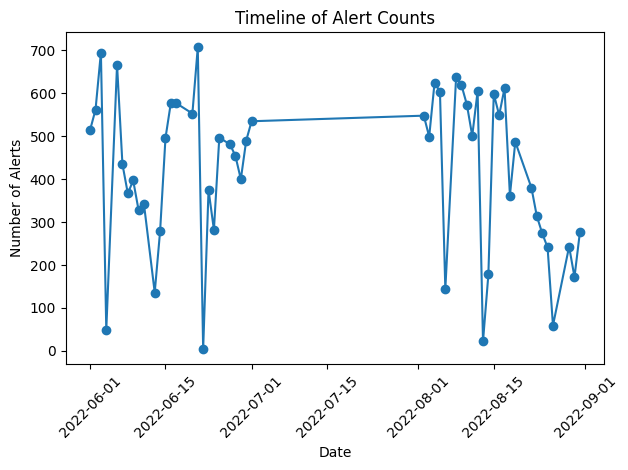

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by date
timeline_df = timeline_df.sort_values(by='Date')

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the timeline of alert counts
ax.plot(timeline_df['Date'], timeline_df['count'], marker='o', linestyle='-')

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Number of Alerts")
plt.title("Timeline of Alert Counts")

# Format x-axis as dates (optional)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()
